In [1]:
# Check Cuda
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
cuda_version = torch.version.cuda

print(f"CUDA available: {cuda_available}")
print(f"CUDA version: {cuda_version}")

# Print the name of the GPU, if available
if cuda_available:
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Test a simple operation on GPU
if cuda_available:
    a = torch.tensor([1.0, 2.0, 3.0]).cuda()
    b = torch.tensor([4.0, 5.0, 6.0]).cuda()
    c = a + b
    print(f"Result of tensor addition on GPU: {c}")


CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4080 SUPER
Result of tensor addition on GPU: tensor([5., 7., 9.], device='cuda:0')


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV

D:\anaconda3\envs\python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
'''
# Do this if you haven't download the data to your local machine
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
'''

'\n# Do this if you haven\'t download the data to your local machine\n# @title Data retrieval\nimport os, requests\n\nfname = "stringer_spontaneous.npy"\nurl = "https://osf.io/dpqaj/download"\n\nif not os.path.isfile(fname):\n  try:\n    r = requests.get(url)\n  except requests.ConnectionError:\n    print("!!! Failed to download data !!!")\n  else:\n    if r.status_code != requests.codes.ok:\n      print("!!! Failed to download data !!!")\n    else:\n      with open(fname, "wb") as fid:\n        fid.write(r.content)\n'

In [5]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())
print(dat['sresp'].shape)
print(dat['xyz'].shape)
print(dat['pupilArea'].shape)
print(len(dat['sresp']))
print(len(dat['pupilArea'][0]))

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])
(11983, 7018)
(3, 11983)
(7018, 1)
11983
1


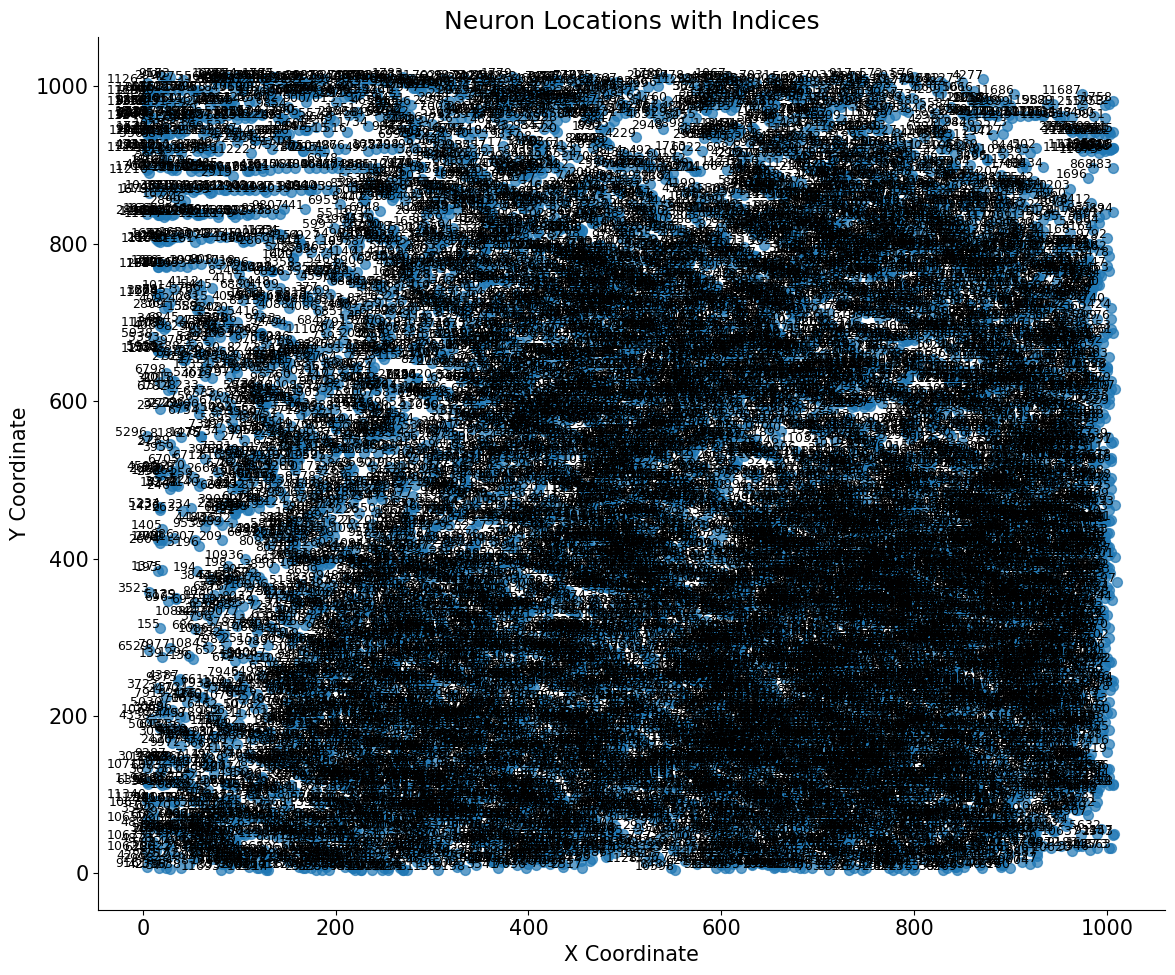

In [6]:
# Plot the spatial location & indexes of the neurons

# Assuming dat['xyz'] contains the coordinates and has shape (3, neurons)
# and dat['sresp'] has shape (neurons, timebins)

# Transpose the neuron locations to get shape (neurons, 3)
neuron_locations = dat['xyz'].T  # Now has shape (neurons, 3)

# Create a scatter plot
plt.figure(figsize=(12, 10))
plt.scatter(neuron_locations[:, 0], neuron_locations[:, 1], s=50, alpha=0.7)

# Annotate each point with its index
for i in range(neuron_locations.shape[0]):
    plt.text(neuron_locations[i, 0], neuron_locations[i, 1], str(i), fontsize=9, ha='right')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Neuron Locations with Indices')
plt.show()

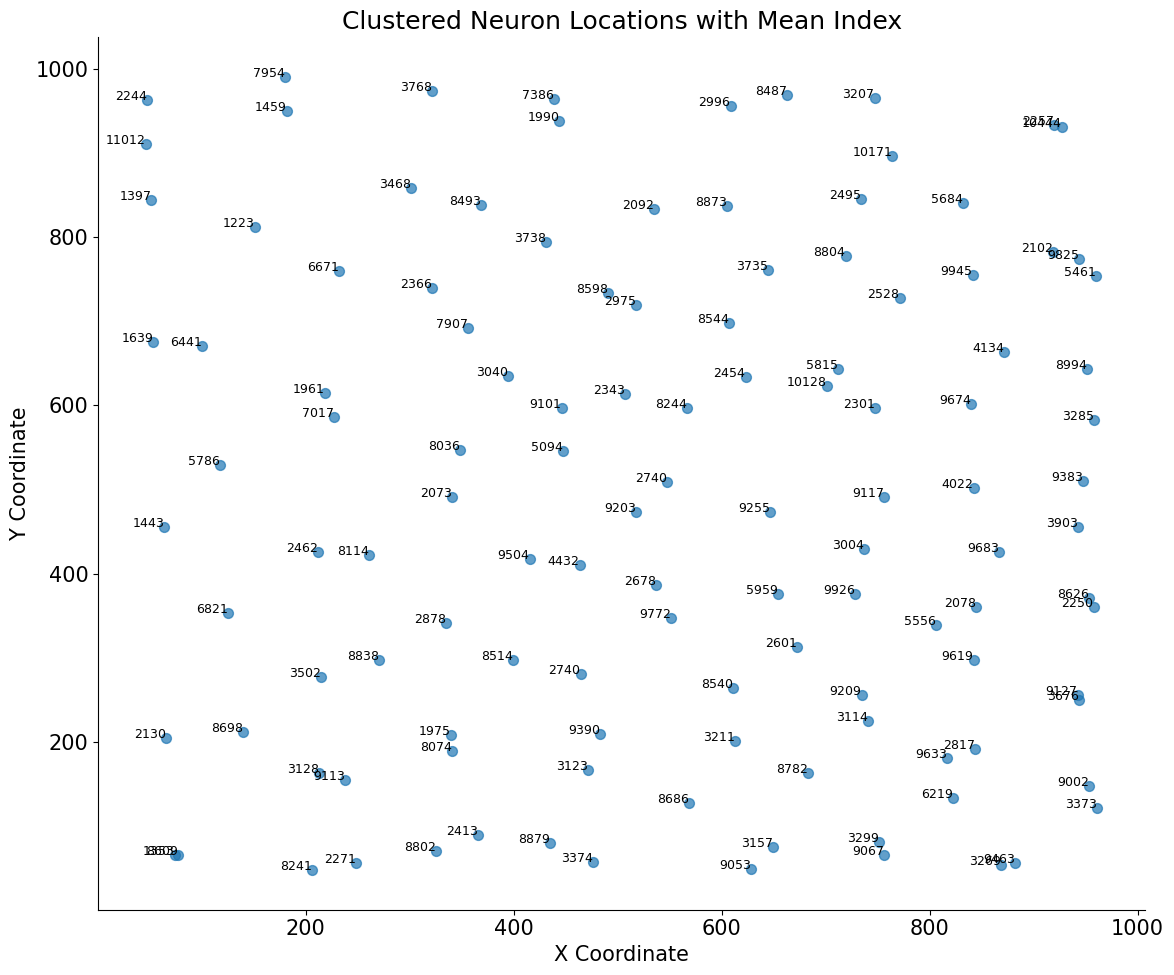

In [7]:
# The above graph is a mess, so we need to do a little bit a clustering for nearby neurons

from sklearn.cluster import KMeans
# Assuming dat['xyz'] contains the coordinates and has shape (3, neurons)
# and dat['sresp'] has shape (neurons, timebins)
neuron_locations = dat['xyz'].T  # Now has shape (neurons, 3)
neuron_indices = np.arange(neuron_locations.shape[0])  # Index array

# Apply KMeans clustering to group neurons into 120 clusters
num_clusters = 120
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(neuron_locations)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate the mean index for each cluster
mean_indices = []
for i in range(num_clusters):
    cluster_points = neuron_indices[kmeans.labels_ == i]
    mean_index = cluster_points.mean()
    mean_indices.append(mean_index)

# Plot the cluster centers with their mean index
plt.figure(figsize=(12, 10))
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=50, alpha=0.7)
for i, mean_index in enumerate(mean_indices):
    plt.text(cluster_centers[i, 0], cluster_centers[i, 1], str(int(mean_index)), fontsize=9, ha='right')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Clustered Neuron Locations with Mean Index')
plt.show()

In [8]:
# The above graph indicate that spatially closer neurons don't have similar indexes, this is not proper for CNN since it extract local features
# We will rearrange the order of the neurons later before we train CNN
# First, we will transform 3D Coordinates to 2D using t-SNE

from sklearn.manifold import TSNE

# Assuming dat['xyz'] is the input 3D coordinates array
xyz = dat['xyz'].T  # Shape (11983, 3)

# Apply t-SNE to reduce dimensions from 3D to 2D
tsne = TSNE(n_components=2, random_state=42)
xyz2d = tsne.fit_transform(xyz)

# Check the shape of the new 2D coordinates
print(xyz2d.shape)  # Should be (11983, 2)

# Save the new 2D coordinates to a local file
np.save('xyz2d.npy', xyz2d)




(11983, 2)


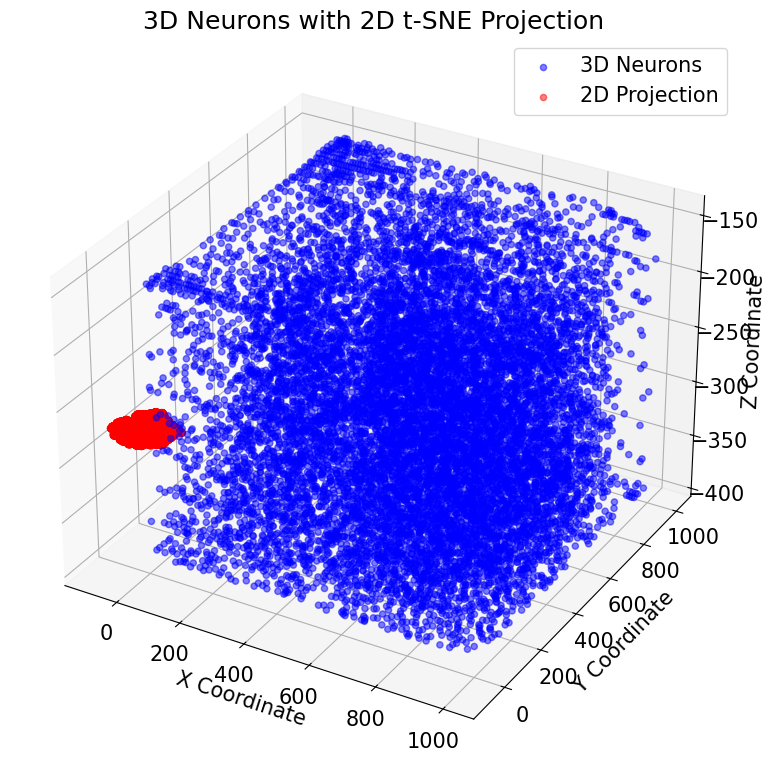

In [9]:
# Next, we will plot the newly-obtained 2D projection within the original 3D space

from mpl_toolkits.mplot3d import Axes3D

# Original 3D coordinates
x, y, z = dat['xyz']

# 2D projection coordinates
x2d, y2d = xyz2d[:, 0], xyz2d[:, 1]

# Plot the 3D scatter plot with the 2D projection plane
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c='b', marker='o', alpha=0.5, label='3D Neurons')

# Add the 2D plane to the plot
# Assume a constant Z value for the 2D plane visualization
z_plane = np.mean(z)  # You can choose another value for visualization
ax.scatter(x2d, y2d, z_plane, c='r', marker='o', alpha=0.5, label='2D Projection')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.legend()
plt.title('3D Neurons with 2D t-SNE Projection')
plt.show()


In [10]:
# The result of tSNE seems unable to preserve relative distance, so let's try PCA now
from sklearn.decomposition import PCA

# Assuming dat['xyz'] is the input 3D coordinates array
xyz = dat['xyz'].T  # Shape (11983, 3)

# Apply PCA to reduce dimensions from 3D to 2D
pca = PCA(n_components=2)
pca2d = pca.fit_transform(xyz)

# Check the shape of the new 2D coordinates
print(pca2d.shape)  # Should be (11983, 2)

# Save the new 2D coordinates to a local file
np.save('pca2d_original.npy', pca2d)


(11983, 2)


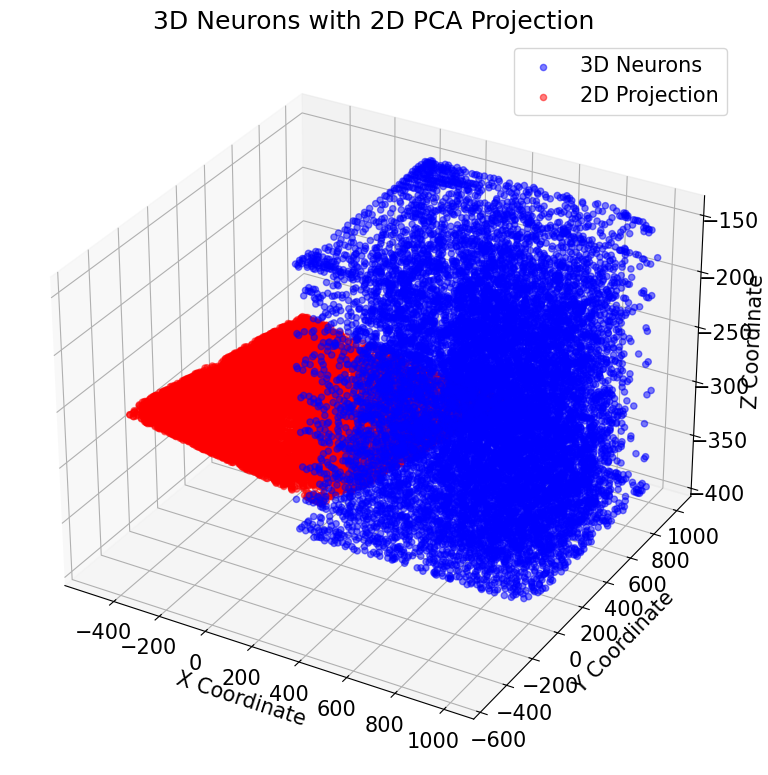

In [11]:
# Plot the 2D plane obtained by PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Original 3D coordinates
x, y, z = dat['xyz']

# 2D projection coordinates
x2d, y2d = pca2d[:, 0], pca2d[:, 1]

# Plot the 3D scatter plot with the 2D projection plane
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c='b', marker='o', alpha=0.5, label='3D Neurons')

# Add the 2D plane to the plot
# Assume a constant Z value for the 2D plane visualization
z_plane = np.mean(z)  # You can choose another value for visualization
ax.scatter(x2d, y2d, z_plane, c='r', marker='o', alpha=0.5, label='2D Projection')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.legend()
plt.title('3D Neurons with 2D PCA Projection')
plt.show()


In [12]:
# Next, we will create a 2D grid for all neurons. The 11983 neurons will be fitted into a 110*110 grid, with average padding for the 117 blank spaces
# Normalize the 2D PCA coordinates to fit within a 110x110 grid

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the 2D coordinates to fit within the range [0, 109]
scaler = MinMaxScaler(feature_range=(0, 109))
pca2d_normalized = scaler.fit_transform(pca2d).astype(int)

# Check the shape and range of the normalized coordinates
print(pca2d_normalized.shape)  # Should be (11983, 2)
print(np.min(pca2d_normalized), np.max(pca2d_normalized))  # Should be within 0 to 109

# Save the new 2D coordinates to a local file
np.save('pca2d_normalized.npy', pca2d_normalized)


(11983, 2)
0 109


In [13]:
# Map each neuron to its new position in the grid with overlap handling
# Initialize the index map
index_map = np.zeros((11983, 2), dtype=int)

# Create a 110x110 grid initialized to -1 (to indicate empty spaces)
grid_size = 110
grid = -1 * np.ones((grid_size, grid_size), dtype=int)

def find_nearest_available(grid, x, y, grid_size):
    """Find the nearest available position in the grid."""
    for dx in range(grid_size):
        for dy in range(grid_size):
            nx, ny = (x + dx) % grid_size, (y + dy) % grid_size
            if grid[nx, ny] == -1:
                return nx, ny
            nx, ny = (x - dx) % grid_size, (y - dy) % grid_size
            if grid[nx, ny] == -1:
                return nx, ny
    return None

# Map neurons to the grid
for i, (x, y) in enumerate(pca2d_normalized):
    if grid[x, y] == -1:
        index_map[i] = [x, y]
        grid[x, y] = i
    else:
        nx, ny = find_nearest_available(grid, x, y, grid_size)
        index_map[i] = [nx, ny]
        grid[nx, ny] = i

# Verify the mapping
print(index_map[:10])  # Print the first 10 mappings

# Save the mapping file
np.save('index_map.npy', index_map)

[[ 14  93]
 [ 13  89]
 [ 17 107]
 [ 16  97]
 [  5  47]
 [ 18 109]
 [ 16 101]
 [  9  65]
 [ 15  93]
 [ 15  91]]


In [14]:
# Create the new sresp_cnn dataset, with zero-padding for the blank spaces
sresp = dat['sresp']

# Initialize the new sresp_cnn dataset with zeros
sresp_cnn = np.zeros((sresp.shape[1], grid_size, grid_size))

# Fill in the new sresp_cnn dataset with the fluorescence intensities
for i, (x, y) in enumerate(index_map):
    sresp_cnn[:, x, y] = sresp[i]

# Verify the shape of the new sresp_cnn dataset
print(sresp_cnn.shape)  # Should be (7018, 110, 110)

# Save the re-arranged dataset
np.save('sresp_cnn.npy', sresp_cnn)

(7018, 110, 110)


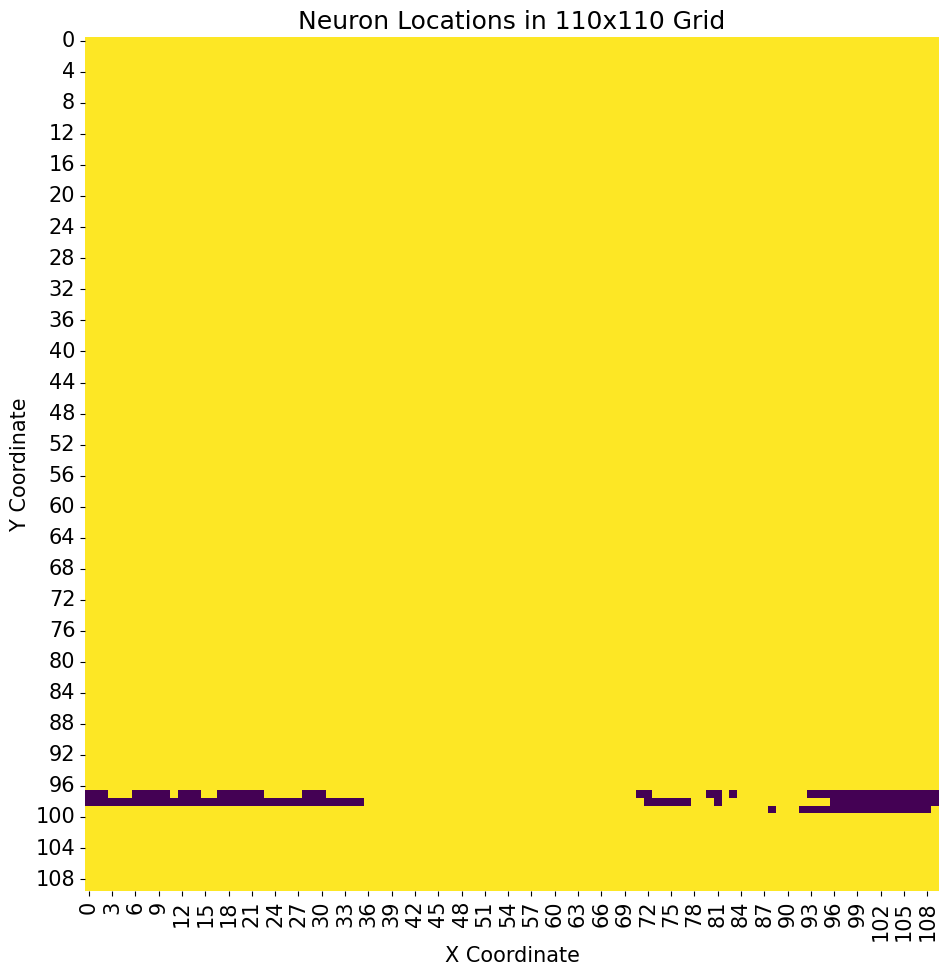

In [15]:
# Create a Binary Mask for the Grid, and plot the Binary Mask as a Heatmap
# This step shows what locations in the 110*110 grid have a correponding neuron
# Plot the neuron locations within the 110x110 grid

import matplotlib.pyplot as plt
import seaborn as sns

# Create a binary mask of the grid
binary_mask = np.zeros((110, 110))

# Fill the mask where there are neurons
for x, y in index_map:
    binary_mask[x, y] = 1

# Plot the binary mask
plt.figure(figsize=(10, 10))
sns.heatmap(binary_mask, cmap='viridis', cbar=False, square=True)
plt.title('Neuron Locations in 110x110 Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [16]:
# We should visualize the newly-obtained indexes' correlation to the original 3D space
# Compare it to cell [12]

# Cluster the neurons based on their 3D locations using KMeans.
from sklearn.cluster import KMeans
import numpy as np

# Assuming dat['xyz'] is the input 3D coordinates array
xyz = dat['xyz'].T  # Shape (11983, 3)

# Perform KMeans clustering to cluster neurons into 120 clusters
kmeans = KMeans(n_clusters=120, random_state=42)
kmeans.fit(xyz)
labels = kmeans.labels_

# Calculate the average 3D location for each cluster
cluster_centers_3d = np.array([xyz[labels == i].mean(axis=0) for i in range(120)])


In [17]:
# Calculate the average newly-obtained 2D index for each cluster.
# Load the mapping relationship
index_map = np.load('index_map.npy')

# Calculate the average 2D index for each cluster
cluster_centers_2d = np.array([index_map[labels == i].mean(axis=0) for i in range(120)])


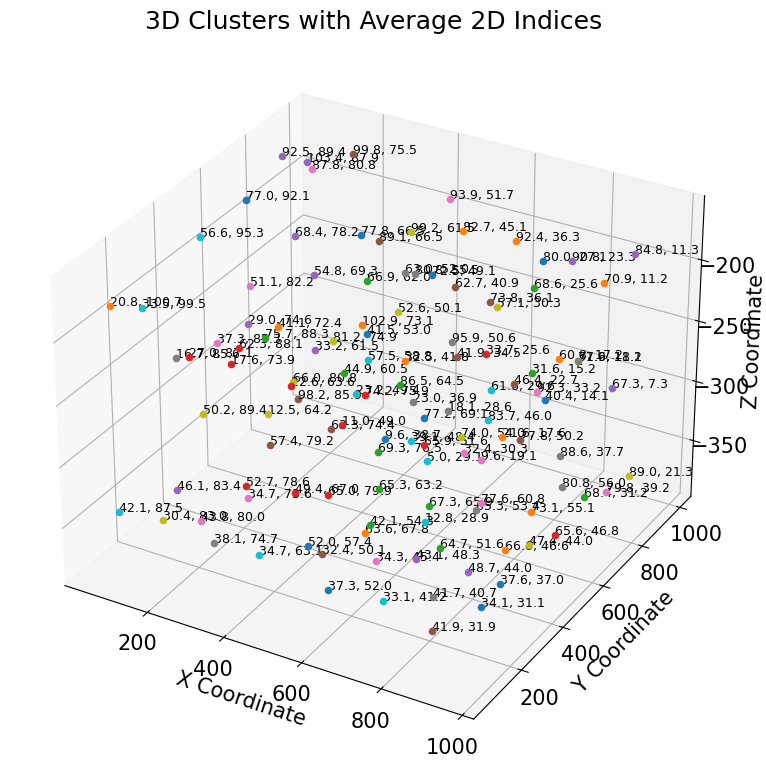

In [18]:
# Plot the clusters in 3D space with their average 2D indices.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot the clusters in 3D space
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster center
for i, (center_3d, center_2d) in enumerate(zip(cluster_centers_3d, cluster_centers_2d)):
    ax.scatter(center_3d[0], center_3d[1], center_3d[2], marker='o')
    ax.text(center_3d[0], center_3d[1], center_3d[2], f'{center_2d[0]:.1f}, {center_2d[1]:.1f}', fontsize=9)

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('3D Clusters with Average 2D Indices')
plt.show()


In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from torchvision import models

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Original dataset preparation code
# Assuming sresp_cnn and dat['pupilArea'] are already loaded
X = sresp_cnn  # Shape (7018, 110, 110)
y = dat['pupilArea'].flatten()  # Shape (7018,)

# Normalize the input data
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[1] * X.shape[2])).reshape(X.shape)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split the data into training and test sets using PyTorch's random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


In [20]:
# Define the CNN model
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim

class ResNet18Regressor(nn.Module):
    def __init__(self):
        super(ResNet18Regressor, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)  # Modify the final layer for regression
    
    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = ResNet18Regressor()
model = model.to(device)


D:\anaconda3\envs\python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
# Train the model
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training parameters
num_epochs = 200

# Lists to store the training and test MSE errors
train_mse = []
test_mse = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU inside the loop
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_mse = running_loss / len(train_loader.dataset)
    train_mse.append(epoch_train_mse)

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU inside the loop
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

    epoch_test_mse = test_loss / len(test_loader.dataset)
    test_mse.append(epoch_test_mse)

    # Print progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training MSE: {epoch_train_mse:.4f}, Test MSE: {epoch_test_mse:.4f}')

    
# Save the model
torch.save(model.state_dict(), 'resnet18_200epochs.pth')


Epoch [1/200], Training MSE: 784072.3106, Test MSE: 605941.7639
Epoch [2/200], Training MSE: 360110.8926, Test MSE: 242274.0325
Epoch [3/200], Training MSE: 90672.5163, Test MSE: 48931.0442
Epoch [4/200], Training MSE: 19898.9026, Test MSE: 31931.7952
Epoch [5/200], Training MSE: 11138.4183, Test MSE: 31799.4249
Epoch [6/200], Training MSE: 8488.9822, Test MSE: 27306.8441
Epoch [7/200], Training MSE: 7149.0375, Test MSE: 27520.3054
Epoch [8/200], Training MSE: 7014.5172, Test MSE: 26190.0088
Epoch [9/200], Training MSE: 7424.1699, Test MSE: 38404.2510
Epoch [10/200], Training MSE: 7280.6765, Test MSE: 26159.5065
Epoch [11/200], Training MSE: 6124.8112, Test MSE: 27147.1854
Epoch [12/200], Training MSE: 6094.8285, Test MSE: 32495.3102
Epoch [13/200], Training MSE: 5730.4185, Test MSE: 34336.9129
Epoch [14/200], Training MSE: 5442.0248, Test MSE: 26170.0730
Epoch [15/200], Training MSE: 4444.3997, Test MSE: 26422.9485
Epoch [16/200], Training MSE: 4728.3564, Test MSE: 25765.0451
Epoch [1

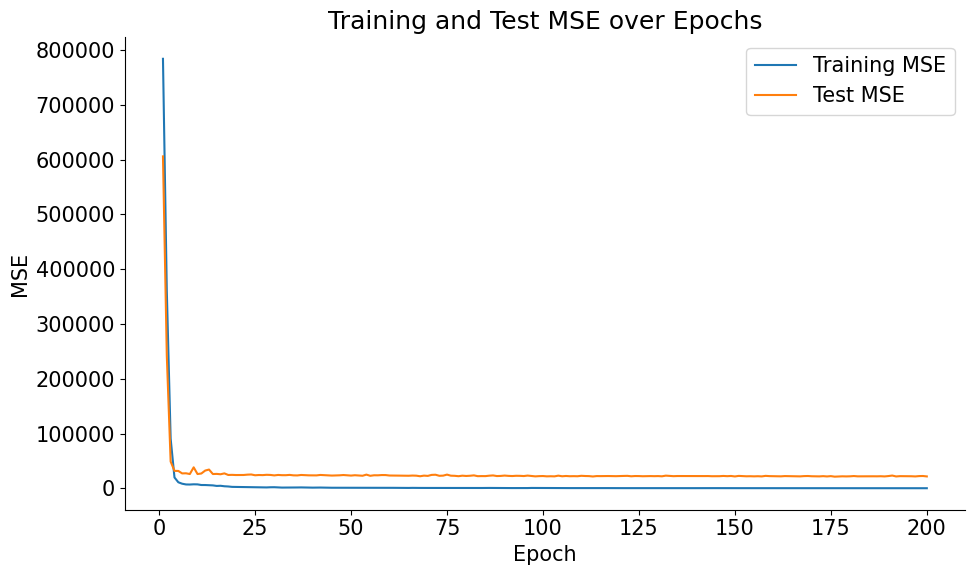

In [22]:
# Plot the MSE errors
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_mse, label='Training MSE')
plt.plot(range(1, num_epochs + 1), test_mse, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Test MSE over Epochs')
plt.show()


In [23]:
import torch
torch.cuda.empty_cache()


In [24]:
import torch

# Check if CUDA is available and print the memory usage
if torch.cuda.is_available():
    print(f"Allocated: {torch.cuda.memory_allocated()} bytes")
    print(f"Cached: {torch.cuda.memory_reserved()} bytes")
else:
    print("CUDA is not available")


Allocated: 200008704 bytes
Cached: 272629760 bytes


In [25]:
'''import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from torchvision import models

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Original dataset preparation code
# Assuming sresp_cnn and dat['pupilArea'] are already loaded
X = sresp_cnn  # Shape (7018, 110, 110)
y = dat['pupilArea'].flatten()  # Shape (7018,)

# Normalize the input data
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[1] * X.shape[2])).reshape(X.shape)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split the data into training and test sets using PyTorch's random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define the CNN model
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim

class ResNet18Regressor(nn.Module):
    def __init__(self):
        super(ResNet18Regressor, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)  # Modify the final layer for regression
    
    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = ResNet18Regressor()
model = model.to(device)

model.load_state_dict(torch.load('resnet18_500epochs.pth'))
'''

'import torch\nimport torch.nn.functional as F\nimport numpy as np\nimport cv2\nimport matplotlib.pyplot as plt\nfrom torch.utils.data import DataLoader, TensorDataset, random_split\nfrom sklearn.preprocessing import StandardScaler\nfrom torchvision import models\n\n# Set random seed for reproducibility\nrandom_seed = 42\ntorch.manual_seed(random_seed)\n\n# Original dataset preparation code\n# Assuming sresp_cnn and dat[\'pupilArea\'] are already loaded\nX = sresp_cnn  # Shape (7018, 110, 110)\ny = dat[\'pupilArea\'].flatten()  # Shape (7018,)\n\n# Normalize the input data\nscaler = StandardScaler()\nX = scaler.fit_transform(X.reshape(-1, X.shape[1] * X.shape[2])).reshape(X.shape)\n\n# Convert to PyTorch tensors\nX_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add channel dimension\ny_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)\n\n# Create TensorDataset\ndataset = TensorDataset(X_tensor, y_tensor)\n\n# Split the data into training and test sets using PyTor

In [26]:
import torch
import numpy as np
import json

# Generate predictions for the test set
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.append(outputs.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)

# Extract X_train, X_test, y_train, y_test from the PyTorch splits
X_train = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))]).squeeze(1).numpy()
y_train = torch.stack([train_dataset[i][1] for i in range(len(train_dataset))]).numpy()
X_test = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))]).squeeze(1).numpy()
y_test = torch.stack([test_dataset[i][1] for i in range(len(test_dataset))]).numpy()

# Ensure the format is compatible with sklearn (2D for features, 1D for target)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.flatten()
y_test = y_test.flatten()

# Convert back to PyTorch tensors for DataLoader
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 110, 110)
X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 110, 110)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Flatten the actual values for comparison
y_test_flat = y_test.cpu().numpy().flatten()
y_pred_flat = y_pred.flatten()

# Calculate the individual squared errors
errors = (y_pred_flat - y_test_flat) ** 2

# Get the indices of the top 100 largest errors
top_100_indices = np.argsort(errors)[-100:][::-1]  # Sorted in descending order

# Get the indices of the bottom 100 smallest errors
bottom_100_indices = np.argsort(errors)[:100]  # Sorted in ascending order

# Create a list of (index, error) tuples for the top 100 errors
top_100_errors = [(int(index), float(errors[index])) for index in top_100_indices]

# Create a list of (index, error) tuples for the bottom 100 errors
bottom_100_errors = [(int(index), float(errors[index])) for index in bottom_100_indices]

# Print the top 100 errors and their indices
print("Top 100 Errors:")
for idx, error in top_100_errors:
    print(f"Time Stamp: {idx}, MSE Error: {error}")

# Print the bottom 100 errors and their indices
print("Bottom 100 Errors:")
for idx, error in bottom_100_errors:
    print(f"Time Stamp: {idx}, MSE Error: {error}")

# Save the top 100 errors to a list
top_100_list = [{"time_stamp": idx, "error": error} for idx, error in top_100_errors]

# Save the bottom 100 errors to a list
bottom_100_list = [{"time_stamp": idx, "error": error} for idx, error in bottom_100_errors]

# Save the lists to JSON files
with open('top_100_errors.json', 'w') as f:
    json.dump(top_100_list, f)

with open('bottom_100_errors.json', 'w') as f:
    json.dump(bottom_100_list, f)


Top 100 Errors:
Time Stamp: 1330, MSE Error: 503894.96875
Time Stamp: 1371, MSE Error: 480462.875
Time Stamp: 689, MSE Error: 400581.4375
Time Stamp: 223, MSE Error: 393707.0625
Time Stamp: 421, MSE Error: 386375.4375
Time Stamp: 753, MSE Error: 352267.6875
Time Stamp: 1225, MSE Error: 338047.125
Time Stamp: 1110, MSE Error: 262379.75
Time Stamp: 314, MSE Error: 254616.828125
Time Stamp: 802, MSE Error: 234984.6875
Time Stamp: 1329, MSE Error: 232238.6875
Time Stamp: 1269, MSE Error: 227042.828125
Time Stamp: 1134, MSE Error: 221429.984375
Time Stamp: 930, MSE Error: 221014.1875
Time Stamp: 1305, MSE Error: 220090.40625
Time Stamp: 541, MSE Error: 218678.734375
Time Stamp: 120, MSE Error: 216479.828125
Time Stamp: 765, MSE Error: 207858.515625
Time Stamp: 1106, MSE Error: 204825.96875
Time Stamp: 210, MSE Error: 201750.4375
Time Stamp: 905, MSE Error: 197974.859375
Time Stamp: 1068, MSE Error: 179911.84375
Time Stamp: 1071, MSE Error: 177449.71875
Time Stamp: 106, MSE Error: 172533.375

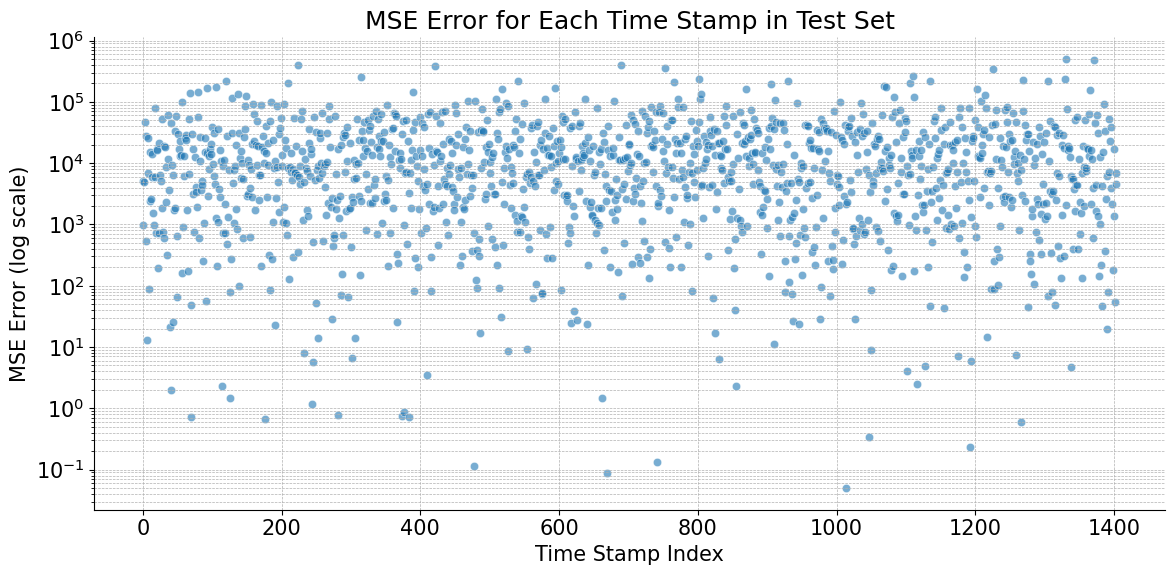

In [27]:
# Generate a graph for all test set errors
import matplotlib.pyplot as plt

# Generate predictions for the test set (if not already done)
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.append(outputs.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)

# Flatten the actual values for comparison
y_test_flat = y_test.cpu().numpy().flatten()
y_pred_flat = y_pred.flatten()

# Calculate the individual squared errors
errors = (y_pred_flat - y_test_flat) ** 2

# Generate the indices for the x-axis
indices = np.arange(len(errors))

# Plot the graph
plt.figure(figsize=(12, 6))
plt.scatter(indices, errors, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.yscale('log')
plt.xlabel('Time Stamp Index')
plt.ylabel('MSE Error (log scale)')
plt.title('MSE Error for Each Time Stamp in Test Set')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


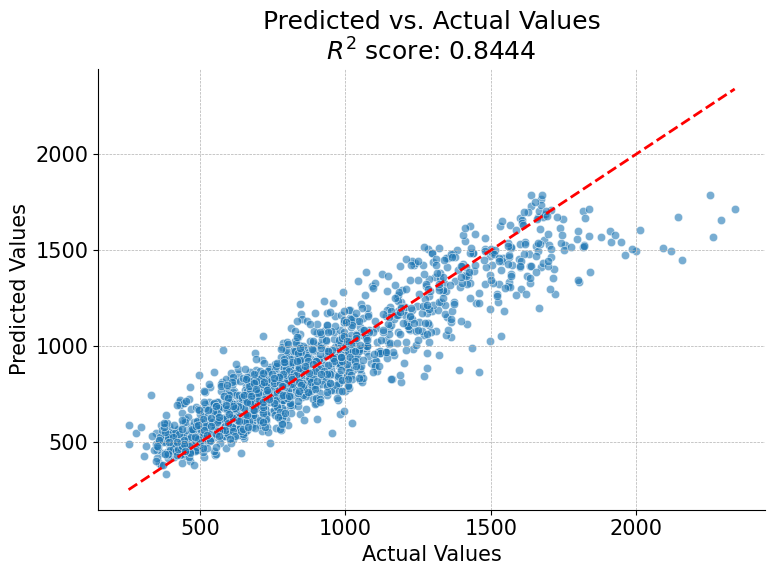

In [28]:
# Set the model to evaluation mode
model.eval()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Generate predictions for the test set
y_pred = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.append(outputs.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)

# Flatten the actual values for comparison
y_test_flat = y_test.cpu().numpy().flatten()
y_pred_flat = y_pred.flatten()

# Calculate the R^2 score
r2 = r2_score(y_test_flat, y_pred_flat)

# Plot the graph
plt.figure(figsize=(8, 6))
plt.scatter(y_test_flat, y_pred_flat, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Predicted vs. Actual Values\n$R^2$ score: {r2:.4f}')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

In [29]:
# Install necessary libraries
!pip install opencv-python

D:\anaconda3\envs\python310\lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated CAM shape: (110, 110)
input_tensor shape: (110, 110)
Generated CAM shape: (110, 110)
input_tensor shape: (110, 110)
Generated CAM shape: (110, 110)
input_tensor shape: (110, 110)
Generated CAM shape: (110, 110)
input_tensor shape: (110, 110)
Generated CAM shape: (110, 110)
input_tensor shape: (110, 110)


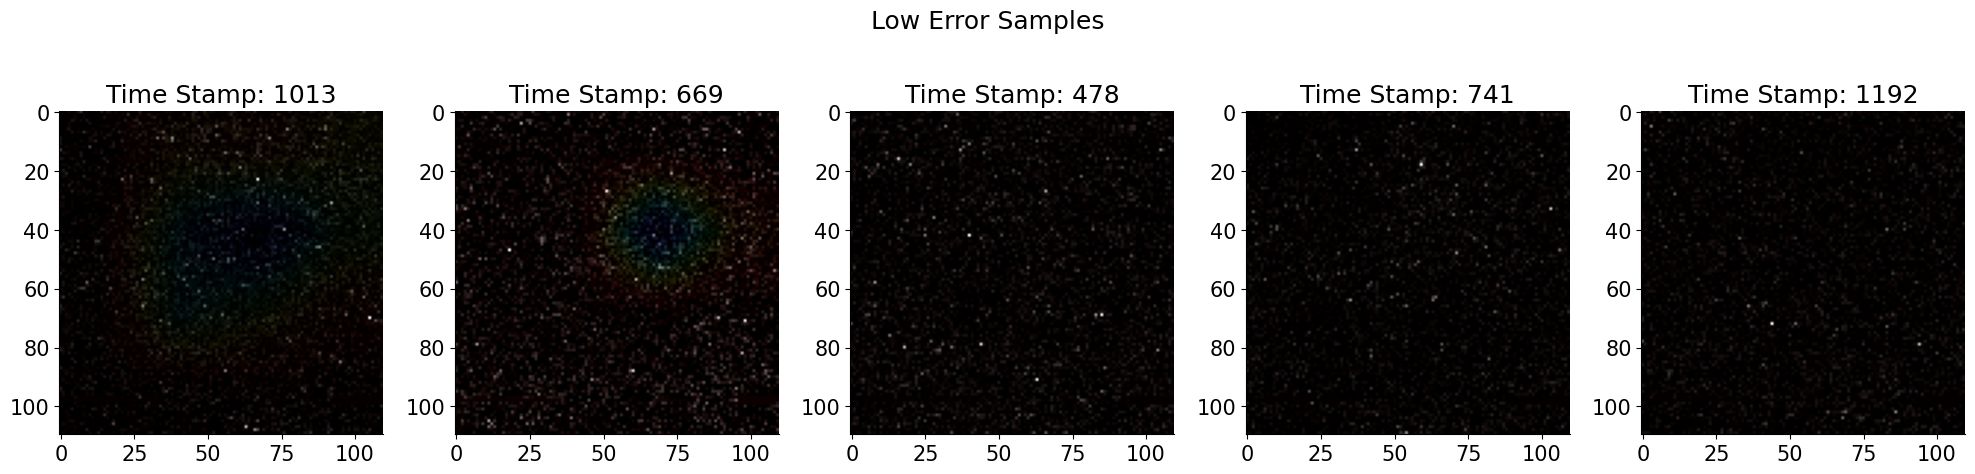

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated CAM shape: (110, 110)
input_tensor shape: (110, 110)
Generated CAM shape: (110, 110)
input_tensor shape: (110, 110)
Generated CAM shape: (110, 110)
input_tensor shape: (110, 110)
Generated CAM shape: (110, 110)
input_tensor shape: (110, 110)
Generated CAM shape: (110, 110)
input_tensor shape: (110, 110)


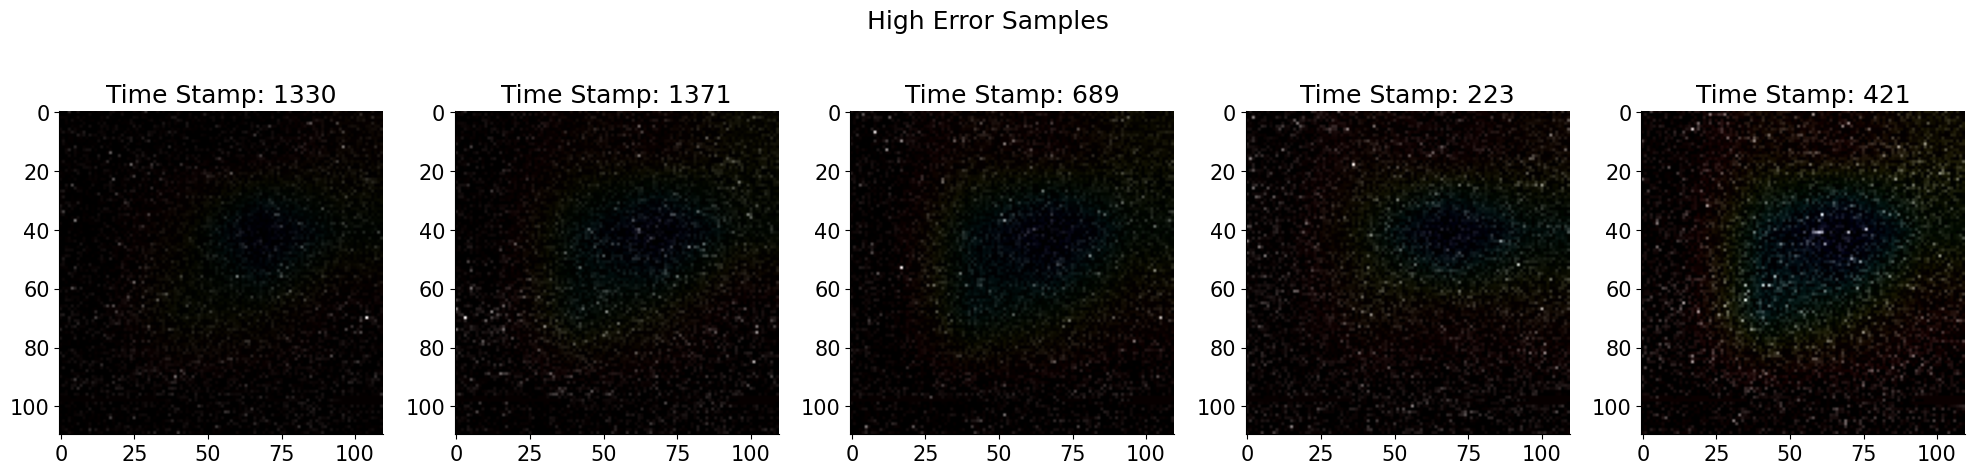

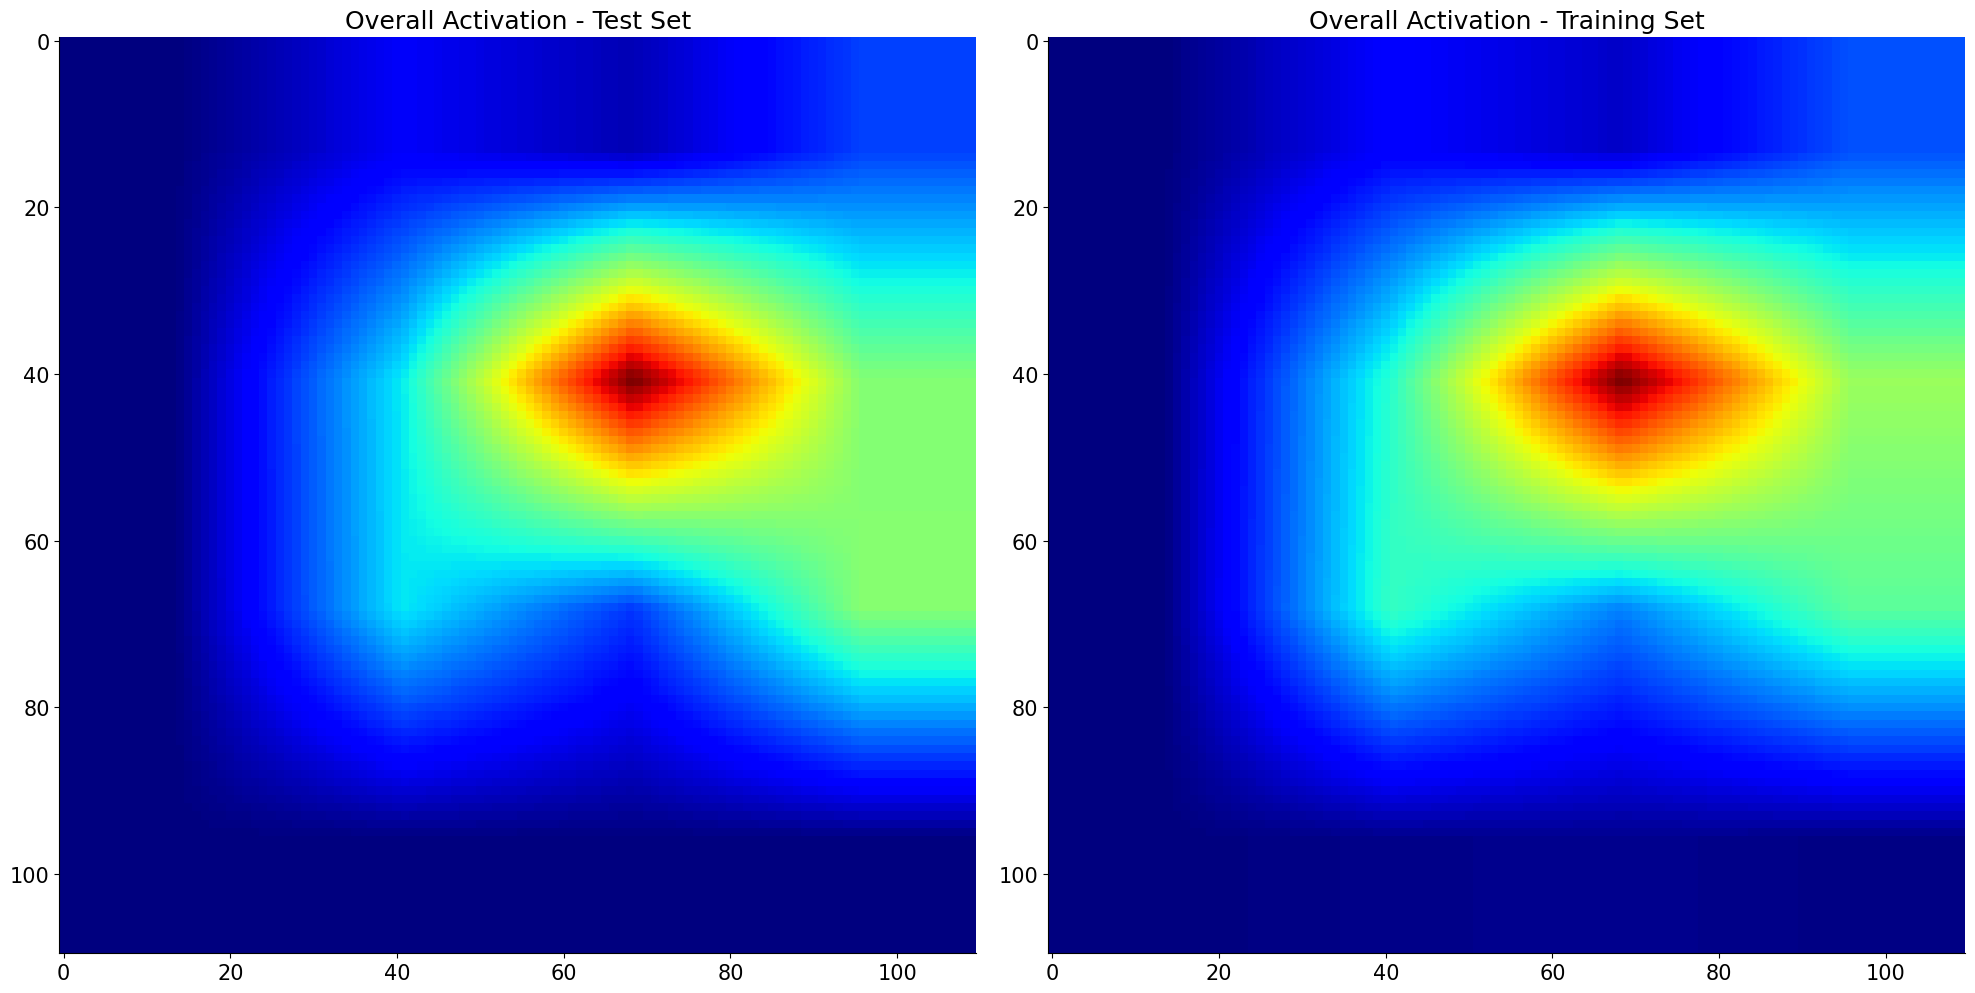

In [30]:

# Visualize the Good predictions and Bad predictions
import torch
import torch.nn.functional as F
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
        output = self.model(input_tensor)
        self.model.zero_grad()
        output[0, target_class].backward()
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam) if np.max(cam) != 0 else cam
        return cam

def apply_colormap_on_image(org_img, activation, colormap_name):
    color_map = cv2.applyColorMap(np.uint8(255 * activation), cv2.COLORMAP_JET)
    color_map = np.float32(color_map) / 255
    overlayed_image = color_map + np.float32(org_img)
    overlayed_image = overlayed_image / np.max(overlayed_image)
    return np.uint8(255 * overlayed_image)

def visualize_cam(input_tensor, cam, ax):
    if input_tensor.ndim == 2:  # If input tensor has no channel dimension, add one
        input_tensor = input_tensor[np.newaxis, :]
    input_tensor = input_tensor.squeeze().cpu().numpy()
    print(f"input_tensor shape: {input_tensor.shape}")  # Debugging statement
    cam = cv2.resize(cam, (input_tensor.shape[0], input_tensor.shape[1]))  # Correct the dimensions here
    cam = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    input_tensor_3ch = np.repeat(input_tensor[:, :, np.newaxis], 3, axis=2)  # Replicate the single channel to 3 channels
    overlayed = heatmap + np.float32(input_tensor_3ch)
    overlayed = overlayed / np.max(overlayed)
    ax.imshow(overlayed)

def generate_gradcam(indices, dataset, title):
    fig, axes = plt.subplots(1, len(indices), figsize=(20, 5))
    for i, idx in enumerate(indices):
        input_tensor = dataset[idx][0].to(device)
        target_class = torch.argmax(model(input_tensor.unsqueeze(0))).item()
        cam = grad_cam.generate_cam(input_tensor, target_class)
        print(f"Generated CAM shape: {cam.shape}")  # Debugging statement
        visualize_cam(input_tensor, cam, axes[i])
        axes[i].set_title(f'Time Stamp: {idx}')
    fig.suptitle(title)
    plt.show()

# Get indices for low and high errors (this part assumes you have the errors computed)
low_error_indices = [idx for idx, _ in bottom_100_errors]
high_error_indices = [idx for idx, _ in top_100_errors]

# Initialize the GradCAM object
target_layer = model.resnet.layer4[1].conv2  # Adjust based on the ResNet-18 architecture
grad_cam = GradCAM(model, target_layer)

# Visualize GradCAM for low and high error samples
generate_gradcam(low_error_indices[:5], test_dataset, 'Low Error Samples')
generate_gradcam(high_error_indices[:5], test_dataset, 'High Error Samples')

# Function to calculate overall activation condition
def overall_activation(dataset):
    activations = []
    for inputs, _ in DataLoader(dataset, batch_size=1):
        inputs = inputs.to(device)
        target_class = torch.argmax(model(inputs)).item()
        cam = grad_cam.generate_cam(inputs.squeeze(0), target_class)
        activations.append(cam)
    mean_activation = np.mean(activations, axis=0)
    return mean_activation

# Compute and visualize overall activation conditions for the test set and training set
test_activation = overall_activation(test_dataset)
train_activation = overall_activation(train_dataset)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_activation, cmap='jet')
axes[0].set_title('Overall Activation - Test Set')
axes[1].imshow(train_activation, cmap='jet')
axes[1].set_title('Overall Activation - Training Set')
plt.show()


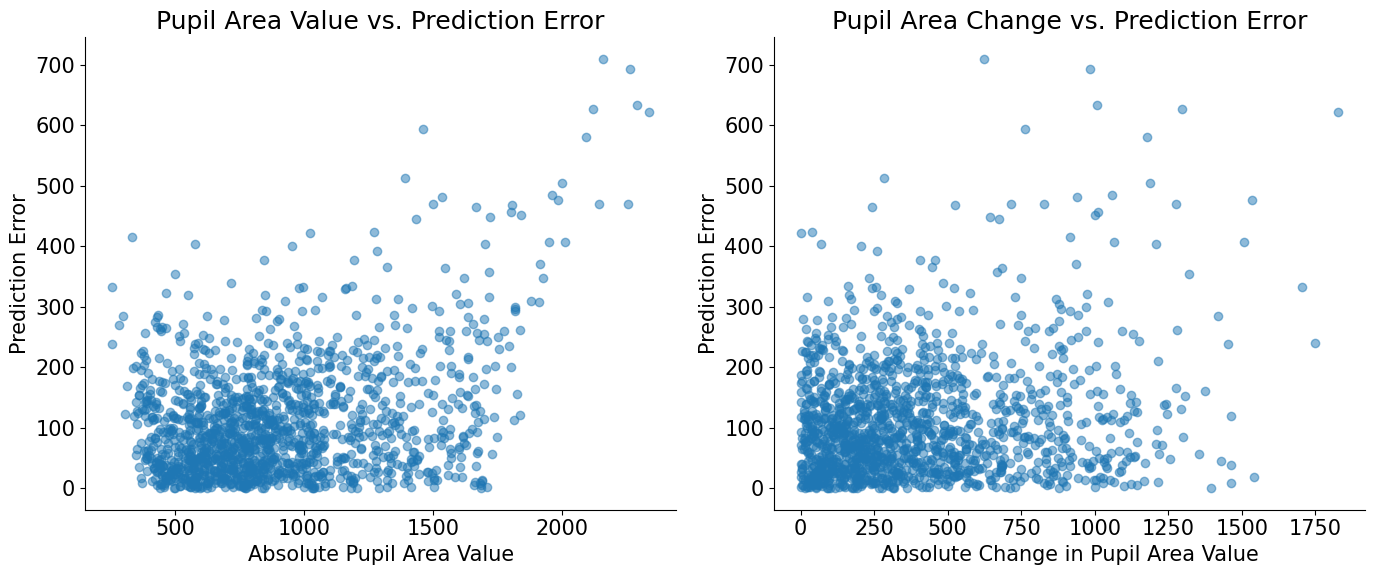

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming model, test_loader, X_test, y_test are already defined

# Step 1: Calculate Prediction Error
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy())

y_pred = np.array(y_pred).flatten()
y_test = y_test.flatten()
prediction_error = np.abs(y_test - y_pred)

# Step 2: Absolute Pupil Area Value
pupil_area_values = y_test

# Step 3: Calculate Absolute Change in Pupil Area
pupil_area_change = np.abs(np.diff(pupil_area_values, prepend=pupil_area_values[0]))

# Step 4: Plot Scatter Plots
plt.figure(figsize=(14, 6))

# Scatter Plot for Pupil Area vs. Prediction Error
plt.subplot(1, 2, 1)
plt.scatter(pupil_area_values, prediction_error, alpha=0.5)
plt.xlabel('Absolute Pupil Area Value')
plt.ylabel('Prediction Error')
plt.title('Pupil Area Value vs. Prediction Error')

# Scatter Plot for Pupil Area Change vs. Prediction Error
plt.subplot(1, 2, 2)
plt.scatter(pupil_area_change, prediction_error, alpha=0.5)
plt.xlabel('Absolute Change in Pupil Area Value')
plt.ylabel('Prediction Error')
plt.title('Pupil Area Change vs. Prediction Error')

plt.tight_layout()
plt.show()



C:\Users\cherr\AppData\Local\Temp\ipykernel_4464\1408566846.py:25: RuntimeWarning: divide by zero encountered in divide
  proportional_change_error = prediction_error / pupil_area_change


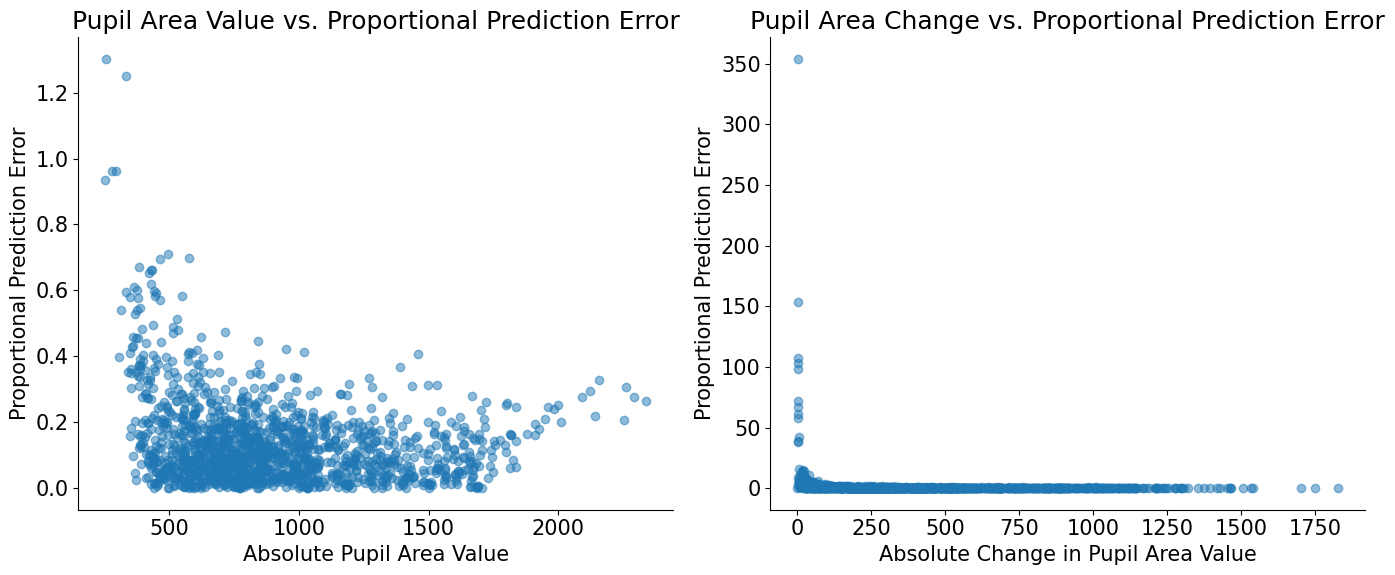

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming model, test_loader, X_test, y_test are already defined

# Step 1: Calculate Prediction Error
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy())

y_pred = np.array(y_pred).flatten()
y_test = y_test.flatten()
prediction_error = np.abs(y_test - y_pred)

# Step 2: Calculate Proportional Error
proportional_error = prediction_error / np.abs(y_test)
proportional_error = np.where(np.abs(y_test) == 0, 0, proportional_error)  # Handle division by zero

# Step 3: Calculate Absolute Change in Pupil Area and Proportional Change
pupil_area_change = np.abs(np.diff(y_test, prepend=y_test[0]))
proportional_change_error = prediction_error / pupil_area_change
proportional_change_error = np.where(pupil_area_change == 0, 0, proportional_change_error)  # Handle division by zero

# Step 4: Plot Scatter Plots
plt.figure(figsize=(14, 6))

# Scatter Plot for Pupil Area Value vs. Proportional Prediction Error
plt.subplot(1, 2, 1)
plt.scatter(np.abs(y_test), proportional_error, alpha=0.5)
plt.xlabel('Absolute Pupil Area Value')
plt.ylabel('Proportional Prediction Error')
plt.title('Pupil Area Value vs. Proportional Prediction Error')

# Scatter Plot for Pupil Area Change vs. Proportional Prediction Error
plt.subplot(1, 2, 2)
plt.scatter(pupil_area_change, proportional_change_error, alpha=0.5)
plt.xlabel('Absolute Change in Pupil Area Value')
plt.ylabel('Proportional Prediction Error')
plt.title('Pupil Area Change vs. Proportional Prediction Error')

plt.tight_layout()
plt.show()
